In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time

# PART 1 - linear case

In [2]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

In [3]:
# Defining initial functions, boundary functions and one exact solution

def european_put(x):
    return np.piecewise(x,[x<=K,x>K],[K-x,0])

def butterfly_spread(x):
    a = np.piecewise(x,[x>=K,x<K],[x-K,0])
    b = 2*np.piecewise(x, [x>=(K+H),x<(K+H)],[x-(K+H),0])
    c = np.piecewise(x, [x>=(K+2*H),x<(K+2*H)],[x-(K+2*H),0])
    return a-b+c

def binary_call(x):
    if (x-K) >= 0:
        f=1
    else: f=0
    return f

def g0_european(t):
    return K*np.exp(-c*t)

def g1(t):
    return 0
    
def uexact(x,t):
    return np.sin(np.pi*x)*np.exp(-t)

def g0_uex(t):
    return 0

def g1_uex(t):
    return np.sin(np.pi*R)*np.exp(-t)

def f_uex(x):
    return np.sin(np.pi*x)

def rhs_uex(x,t):
    return np.exp(-t)*np.sin(np.pi*x)*(c+sigm**2*x**2*np.pi**2/2-1)-np.exp(-t)*np.cos(np.pi*x)*np.pi*r*x

# Place-holder function
def zero(x,t):
    return 0


In [4]:
def forward_euler(f, sigm, r, c, R, g0=0, g1=0, M=10, N=100, T=0.5, RHS=zero):
    
    # Defining time steps and spatial steps
    k=T/N
    h=R/M

    U = np.zeros((M+1,N+1))    # Matrix
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    
    # Useful to shorten code
    a = sigm**2*x**2/(2*h**2)
    b = r*x/(2*h)
    
    # Scheme included in a tridiagonal matrix
    A = tridiag(k*(a[2:]-b[2:]),1-k*(2*a[1:-1]+c),k*(a[0:-2]+b[0:-2]), M-1)
    
    # Initial and boundary conditions
    U[:,0] = np.vectorize(f)(x)
    U[0,:] = np.vectorize(g0)(t)
    U[-1,:] = np.vectorize(g1)(t)
    
    for n in range(N):
        q = np.zeros(M-1)                   #vector with boundary conditions
        q[0] = g0(t[n]) * k*(a[1]-b[1]) 
        q[-1] = g1(t[n]) * k*(a[M-1] + b[M-1])
        U[1:-1, n+1] = A.dot(U[1:-1,n]) + q + k*RHS(x[1:-1], t[n])

    return x,t,U


In [5]:
def backward_euler(f, sigm, r, c, R, g0=0, g1=0, M=10, N=100, T=0.5,RHS=zero):
    
    # Defining time steps and spatial steps
    k=T/N
    h=R/M

    U = np.zeros((M+1,N+1))    # Matrix
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    
    # Useful to shorten code
    a = sigm**2*x**2/(2*h**2)
    b = r*x/(2*h)
    
    # Scheme included in a tridiagonal matrix
    A = tridiag(b[2:]-a[2:],1/k+2*a[1:-1]+c,-a[0:-2]-b[0:-2],M-1)
    
    # Initial and boundary conditions
    U[:,0] = np.vectorize(f)(x)
    U[0,:]=np.vectorize(g0)(t)
    U[-1,:]=np.vectorize(g1)(t) 
    
    for n in range(N):
        q = np.zeros(M-1)            #vector with boundary conditions 
        q[0]=g0(t[n]) * (a[1]-b[1])
        q[-1]=g1(t[n]) * (a[M-1] + b[M-1])
        U[1:-1, n+1] = np.linalg.solve(A, 1/k*U[1:-1,n]+q+RHS(x[1:-1],t[n]))
                                      

    return x,t,U

In [6]:
def CN(f, sigm, r, c, R, g0=0, g1=0, M=10, N=100, T=0.5, RHS=zero):
    
    # Defining time steps and spatial steps
    k=T/N
    h=R/M
    
    U = np.zeros((M+1,N+1))    # Matrix
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    
    # Useful to shorten the code 
    a = sigm**2*x**2/(2*h**2)
    b = r*x/(2*h)
    
    # Scheme included in matrices
    A = tridiag(0.5*(-a[2:]+b[2:]),a[1:-1]+1/k+c/2,-0.5*(a[0:-2]+b[0:-2]),M-1) #Containing coeff of U^(n+1)
    B = tridiag(0.5*(a[2:]-b[2:]),1/k - a[1:-1]-c/2,0.5*(a[0:-2]+b[0:-2]),M-1) #Containing coeff of U^n
    
    # Initial and boundary conditions 
    U[:,0] = np.vectorize(f)(x)
    U[0,:] = np.vectorize(g0)(t)
    U[-1,:] = np.vectorize(g1)(t)
    
    for n in range(N):
        q = np.zeros(M-1)            # Vector with boundary conditions
        q[0]=g0(t[n]) * (a[1]-b[1])
        q[-1]=g1(t[n]) * (a[M-1]+b[M-1])
        U[1:-1, n+1] = np.linalg.solve(A, (B@U[1:-1,n]+q+(RHS(x[1:-1],t[n])+RHS(x[1:-1],t[n+1]))/2))
                                           
    return x,t,U

In [7]:
#Neumann boundary conditions, U_x(R,t)=0

def forward_euler_fictitious(f, sigm, r, c, R, g0=0, g1=0, M=10, N=100, T=0.5):
    
    k=T/N
    h=R/M

    U = np.zeros((M+2,N+1))    # Matrix
    x = np.linspace(0,R,M+2)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    
    a = sigm**2*x**2/(2*h**2)
    b = r*x/(2*h)
 
    A = tridiag(k*(a[2:]-b[2:]),1-k*(2*a[1:-1]+c),k*(a[:-2]+b[:-2]), M)
    
    #Filling in the last two elements in the last row to account for the fictitious node
    A[M-1,-2] = 2*k*a[-2]
    A[M-1,-1] = 1-2*k*(a[-2]+c)
    
    U[:,0] = np.vectorize(f)(x)
    U[0,:] = np.vectorize(g0)(t)
    
    for n in range(N):
        q = np.zeros(M)       #vector with boundary conditions
        q[0]=g0(t[n]) * k*(a[1]-b[1]) 
        U[1:-1, n+1] = A.dot(U[1:-1,n]) + q
        
    U[-1,:] = U[-2,:]
    return x,t,U

In [8]:
# Neumann Boundary conditions, u_xx(R,t)=0
def forward_euler_fictitious2(f, sigm, r, c, R, g0=0, g1=0, M=10, N=100, T=0.5):
    
    k=T/N
    h=R/M

    U = np.zeros((M+2,N+1))    # Matrix
    x = np.linspace(0,R,M+2)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    
    a = sigm**2*x**2/(2*h**2)
    b = r*x/(2*h)
 
    A = tridiag(k*(a[2:]-b[2:]),1-k*(2*a[1:-1]+c),k*(a[:-2]+b[:-2]), M)
    
    #Filling in the last two elements in the last row to account for the fictitious node
    A[M-1,-2] = -k*2*b[-2]
    A[M-1,-1] = 1+k*(2*b[-2]+c)

    U[:,0] = np.vectorize(f)(x)
    U[0,:] = np.vectorize(g0)(t)
    
    for n in range(N):
        q = np.zeros(M)       #vector with boundary conditions
        q[0]=g0(t[n]) * k*(a[1]-b[1]) 
        U[1:-1, n+1] = A.dot(U[1:-1,n]) + q 
    
    U[-1,:] = 2*U[-2,:]-U[-3,:]
    
    return x,t,U

In [9]:
# Defining constants
c = 1
sigm = 1
r = 0.2
K = 0.4
H = 0.4
R = 1

In [10]:
# Plotting function
def plot_solution(x, t, U, txt='Numerical Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={'projection' : '3d'})
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt)

# Plotting the exact solution
def plot_exact_solution(f):
    M=50
    N=1000
    xs = np.linspace(0,R,M+1)
    ts = np.linspace(0,1, N+1)
    fig=plt.figure()
    ax = fig.gca(projection='3d')
    X,T = np.meshgrid(xs, ts) # grid of point
    Z = f(X, T) # evaluation of the function on the grid
    ax.plot_surface(T, X, Z, cmap=cm.coolwarm)
    ax.view_init(azim=30)
    plt.title("Analytical solution")
    
# Plotting function for three schemes and the exact solution    
def plot_four_solutions(U1, U2, U3, uexact, angle=-30, title1="Forward Euler", title2="Backward Euler", title3="crank-Nicolson",title4="Analytic", title="Comparison of methods and analytic solution"
                        , R_val=None, T_val=None, M=20, N=1000):
    if (R_val==None):
        R_val=np.ones(3)*R

    if (T_val==None):
        T_val=np.ones(3)*1
    
    x1=np.linspace(0, R_val[0], len(U1[:,])) 
    t1=np.linspace(0, T_val[0], len(U1[0]))
    tt1, xx1 = np.meshgrid(t1, x1)
    x2=np.linspace(0, R_val[1], len(U2[:,])) 
    t2=np.linspace(0, T_val[1], len(U2[0]))
    tt2, xx2 = np.meshgrid(t2, x2)
    x3=np.linspace(0, R_val[2], len(U3[:,])) 
    t3=np.linspace(0, T_val[2], len(U3[0]))
    tt3, xx3 = np.meshgrid(t3, x3)
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(17, 4), subplot_kw={"projection": "3d"})
    ax[0].plot_surface(tt1, xx1, U1, cmap=cm.coolwarm)
    ax[0].view_init(azim=angle)
    ax[0].set_title(title1)
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[1].plot_surface(tt2, xx2, U2, cmap=cm.coolwarm)
    ax[1].view_init(azim=angle)
    ax[1].set_title(title2)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('x')
    ax[1].set_zlabel('u')
    ax[2].plot_surface(tt3, xx3, U3, cmap=cm.coolwarm)
    ax[2].view_init(azim=angle)
    ax[2].set_title(title3)
    ax[2].set_xlabel('t')
    ax[2].set_ylabel('x')
    ax[2].set_zlabel('u')
    
    xs = np.linspace(0,R,M+1)
    ts = np.linspace(0,1, N+1)
    X3,T3 = np.meshgrid(xs, ts)
    Z = uexact(X3, T3) # evaluation of the function on the grid
    ax[3].set_title(title4)
    ax[3].plot_surface(T3, X3, Z, cmap=cm.coolwarm)
    ax[3].view_init(azim=angle)
    ax[3].set_xlabel('t')
    ax[3].set_ylabel('x')
    ax[3].set_zlabel('u')
    fig.tight_layout()

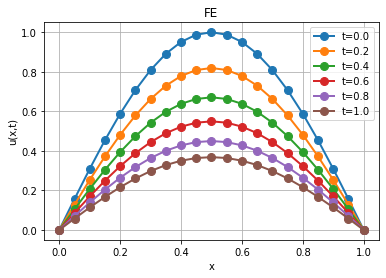

In [11]:
x1,t1,U1 = forward_euler(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=1000, T=1,RHS=rhs_uex)

# Plot the numerical solution at some points in time
plt.figure()
plt.clf()
tplots = np.linspace(0,t1[-1],6)
k = t1[1]-t1[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x1,U1[:,n],'-o',label='t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("FE")
plt.legend()
plt.show()

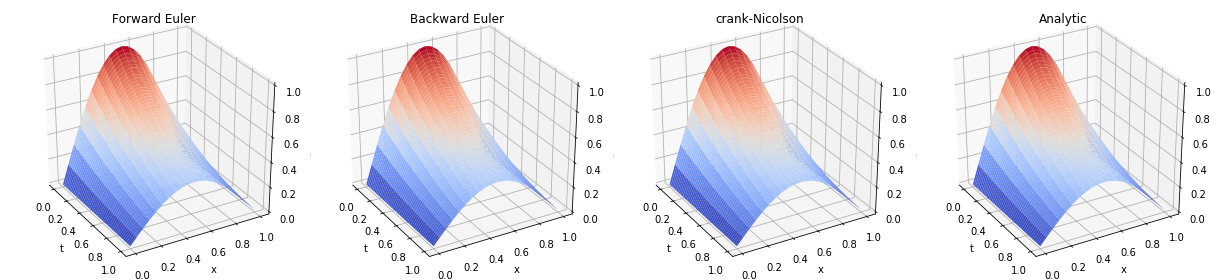

In [12]:
x1,t1,U1 = forward_euler(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=1000, T=1,RHS=rhs_uex)
x2,t2,U2 = backward_euler(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=1000, T=1,RHS=rhs_uex)
x3,t3,U3 = CN(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=1000, T=1,RHS=rhs_uex)
plot_four_solutions(U1, U2, U3, uexact)

**Spatial convergence**

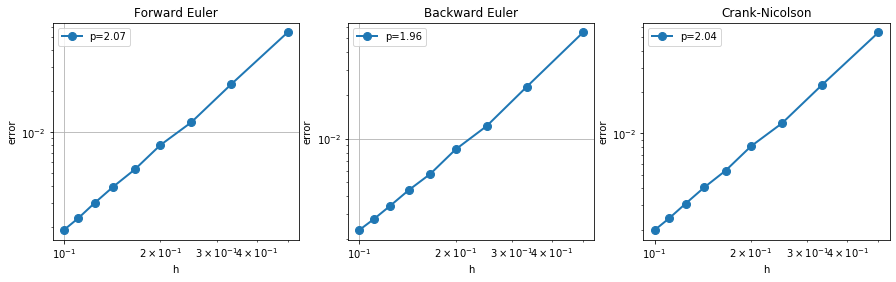

In [13]:
def convergence_h(u_exact, solver=forward_euler): 
    P = 9
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 2
    for p in range(P):
        x, t, U = solver(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=M, N=1000, T=1,RHS = rhs_uex)
        Eh = u_exact(x,t[-1]) - U[:,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M +=1
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

H, E, p = convergence_h(uexact)
ax[0].loglog(H,E,'o-', label='p={:.2f}'.format(p))
ax[0].set_xlabel('h')
ax[0].set_ylabel('error')
ax[0].set_title("Forward Euler")
ax[0].legend()


H, E, p = convergence_h(uexact,backward_euler)
ax[1].loglog(H,E,'o-', label='p={:.2f}'.format(p))
ax[1].set_xlabel('h')
ax[1].set_ylabel('error')
ax[1].set_title("Backward Euler")
ax[1].legend()


H, E, p = convergence_h(uexact,CN)
ax[2].loglog(H,E,'o-', label='p={:.2f}'.format(p))
ax[2].set_xlabel('h')
ax[2].set_ylabel('error')
ax[2].set_title("Crank-Nicolson")
ax[2].legend()

plt.grid()
plt.show()

**Temporal convergence**

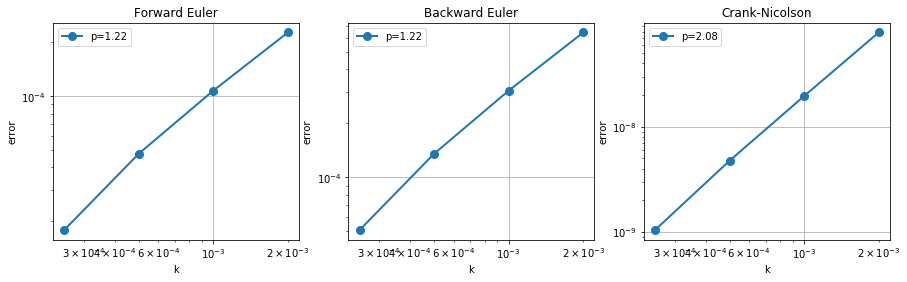

In [14]:
def convergence_k(u_exact, solver=forward_euler): 
    P = 4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    N = 500
    
    for p in range(P):
        x, t, U = solver(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=N, T=1,RHS=rhs_uex)
        Eh = U_ref[:,-1]-U[:,-1]
        Hconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N = 2*N
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

# Plotting convergence order
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

x, t, U_ref = forward_euler(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=10000, T=1,RHS=rhs_uex)
H, E, p = convergence_k(uexact)
ax[0].loglog(H,E,'o-', label='p={:.2f}'.format(p))
ax[0].set_xlabel('k')
ax[0].set_ylabel('error')
ax[0].set_title("Forward Euler")
ax[0].legend()


x, t, U_ref = backward_euler(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=10000, T=1,RHS=rhs_uex)
H, E, p = convergence_k(uexact,backward_euler)
ax[1].loglog(H,E,'o-', label='p={:.2f}'.format(p))
ax[1].set_xlabel('k')
ax[1].set_ylabel('error')
ax[1].set_title("Backward Euler")
ax[1].legend()

x, t, U_ref = CN(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=10000, T=1,RHS=rhs_uex)
H, E, p = convergence_k(uexact,CN)
ax[2].loglog(H,E,'o-', label='p={:.2f}'.format(p))
ax[2].set_xlabel('k')
ax[2].set_ylabel('error')
ax[2].set_title("Crank-Nicolson")
ax[2].legend()
plt.show()


**Testing runtime**

In [15]:
#Checking which method is faster when all inputvalues are the same 
#We choose to run each method 100 times to get numbers big enough to differentiate.

n = 100
time0 = time.time()
for i in range(n): 
    x1,t1,U1 = forward_euler(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=1000, T=1)
time1 = time.time()

total_n = time1-time0
format_total_n = round(total_n,3)
print(f' Computational time for 100 executions of Forward Euler is: {format_total_n}')

time0 = time.time()
for i in range(n): 
    x1,t1,U1 = backward_euler(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=1000, T=1)
time1 = time.time()

total_n = time1-time0
format_total_n = round(total_n,3)
print(f' Computational time for 100 executions of Backward Euler is: {format_total_n}')

time0 = time.time()
for i in range(n): 
    x1,t1,U1 = CN(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=1000, T=1)
time1 = time.time()

total_n = time1-time0
format_total_n = round(total_n,3)
print(f' Computational time for 100 executions of Crank-Nicolson is: {format_total_n}')


 Computational time for 100 executions of Forward Euler is: 3.415
 Computational time for 100 executions of Backward Euler is: 50.975
 Computational time for 100 executions of Crank-Nicolson is: 50.518


**Fictitious node in $X_{M+1}$**

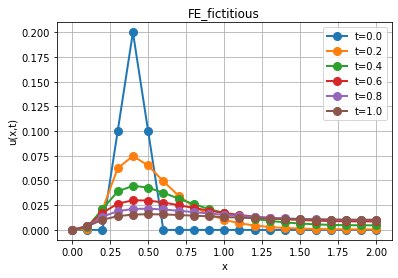

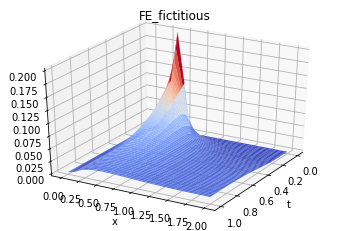

In [16]:
K = 0.2
H = 0.2
c = 1
sigm = 1
r = 0.2
R = 2
x4,t4,U4 = forward_euler_fictitious(butterfly_spread, sigm, r, c, R, g1, g1, M=19, N=1000, T=1)

# Plot the solution at some points in time
plt.figure()
plt.clf()
tplots = np.linspace(0,t4[-1],6)
k = t4[1]-t4[0]
for tn in tplots:
    n = int(tn/k)
    tn =n*k
    plt.plot(x4,U4[:,n],'-o',label='t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("FE_fictitious")
plt.legend()
plt.show()

plot_solution(x4,t4,U4,txt="FE_fictitious")
plt.show()

**Checking how the error varies as R increases**

In [17]:
c=1
sigm=0.4
r=0.05
K=0.4
H=0.05

print("--------")
for i in range(1,19):
    R=i
    x,t,U=forward_euler(f_uex, sigm, r, c, R, g0_uex, g1_uex, M=20, N=100, T=1,RHS=rhs_uex)
    T, X = np.meshgrid(t,x)
    print(np.amax(abs(U-uexact(X,T))))

--------
0.001577249810894077
0.002019918455959502
0.010148612752098662
0.02262508996363255
0.042062256325133496
0.06232203898677735
0.08587621910707832
0.12385081025221956
0.16951632133221728
0.22049545810367088
0.27411545300495255
0.32678785580066294
0.38897925097462815
0.49141626677216443
0.608079988438679
0.6951330108395631
0.8478072813877332
1.0029036217995748


# Part 2 - nonlinear case

In [18]:
# define the initial conditions
def europeanPut(x, K, H):
    return np.piecewise(x, [x <= K, x > K], [K-x, 0])

def butterflySpread(x, K, H):
    return np.piecewise(x, [x    <= K,
                          K    <= x and x <= K+H,
                          K+H  <= x and x <= K+2*H,
                          K+2*H <= x],
                          [0, -K+x, K+2*H-x, 0])

def binaryCall(x, K, H):
    return np.piecewise(x, [x < K, x >= K], [0, 1])


# zero boundary
def zero2(t, K, c, R=None):
    return 0

# one boundary
def one(t, K, c, R=None):
    return 1


# Exact solution with boundaries and initial condition

def uex(x,t):
    return -x**2-t**2

def g0_u(t):
    return -t**2

def g1_u(x,t):
    return -R**2-t**2

def f_u(x):
    return -x**2 

def rhs_u(x,t,s1,s2,phi):
    return -2*t + x**2*phi(-2)

In [19]:
# define Black-Scholes PDE object
class BlackScholesPDE(object):
  
  def __init__(self, f, g0, g1, R, T, sigma, r, c, K, H, stop):
    
    self.f = f             # initial condition; --------------------------------- function of space
    self.g0 = g0           # left boundary condition; --------------------------- function of time
    self.g1 = g1           # right boundary condition; -------------------------- function of time       
    self.R = R             # right spatial boundary; ---------------------------- positive real number
    self.T = T             # temporal boundary; --------------------------------- positive real number
    self.sigma = sigma     # volatility; ---------------------------------------- positive real number
    self.r = r             # interest rate; ------------------------------------- real number between 0 and 1
    self.c = c             # dividends; ----------------------------------------- positive real number
    self.K = K             # strike price 1; ------------------------------------ positive real number
    self.H = H             # strike price 2; ------------------------------------ positive real number
    self.stop = stop       # spatial boundary definining region of interest; ---- positive real number

In [20]:
s1 = 1
s2 = 2
def phi(x):
    return s1**2 + (s2**2 - s1**2)/2 * (1 + 2/np.pi * np.arctan(x))

# second order central difference
def deltasq_x(arr):
    return arr[2:] - 2*arr[1:-1] + arr[:-2]

In [42]:
def IMEX(bvp, M, N, RHS=zero):

    # bvp: ------ Black-Scholes boundary value problem with specific parameters
    # method: --- numerical method for solving the BVP
    # M: -------- number of spatial intervals
    # N: -------- number of temporal intervals
    
    # Step sizes in space and time
    h = bvp.R/M
    k = bvp.T/N

    # spatial indeces
    m = np.linspace(0, M, M+1)

    # Print step sizes and r
    print(f'h = {h}, k = {k}, r/sigma^2 = {bvp.r/bvp.sigma**2}, kR^2/h^2 sigma^2 + kc = {k/h**2 * bvp.R**2 * bvp.sigma**2 + k*bvp.c}')

    # Initialize solution
    # Spatial axis downward, temporal axis rightward
    U = np.zeros((M+1, N+1))

    # Space and time grids
    x = np.linspace(0,bvp.R,M+1)   
    t = np.linspace(0,bvp.T,N+1)  

    # Insert initial condition into first column
    U[:,0] = np.vectorize(bvp.f)(x, bvp.K, bvp.H)

    # Insert boundary conditions into first and last row
    U[0]  = np.vectorize(bvp.g0)(t, bvp.K, bvp.c)
    U[-1] = np.vectorize(bvp.g1)(t, bvp.K, bvp.c)
    
    for n in range(N):

        phi_n = phi(1/h**2 * deltasq_x(U[:, n]))

        g_n = 1/2 *  k * m[1:-1]**2 * phi_n
        a_n = 1   +  k * m[1:-1]**2 * phi_n

        b = np.zeros(M-1)
        b[0]  = bvp.g0(t[n+1], bvp.K, bvp.c)
        b[-1] = bvp.g1(t[n+1], bvp.K, bvp.c)
    
        b *= g_n 
  

        A_n = np.diag(-g_n[1:], k = -1) + np.diag(a_n, k = 0) + np.diag(-g_n[:-1], k = 1)

        U[1:-1, n+1] = np.linalg.solve(A_n, U[1:-1, n] + b )
                                       #+ k*RHS(x[1:-1],t[n],s1,s2,phi))
    
    # extract solution only in domain of interest
    x = x[x <= bvp.stop]
    U = U[:len(x)]

    return x, t, U

In [43]:
ww = BlackScholesPDE(f = butterflySpread, 
                              g0=zero2, g1=one,
                              R = 120, T = 1, 
                              sigma = 0.1, r = 0.02, c = 2, 
                              K = 5, H = 5,
                              stop = 20)

x, t, U = IMEX(ww, 120, 1000)

h = 1.0, k = 0.001, r/sigma^2 = 1.9999999999999996, kR^2/h^2 sigma^2 + kc = 0.14600000000000005


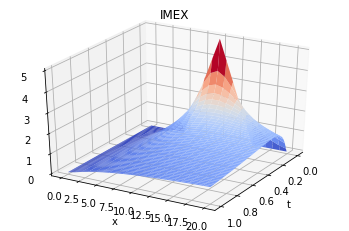

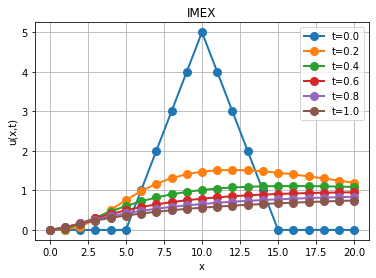

In [37]:
#Butterfly spread 

plot_solution(x, t, U, txt = "IMEX")

# Plot the solution at some points in time
plt.figure()
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn =n*k
    plt.plot(x,U[:,n],'-o',label='t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("IMEX")
plt.legend()
plt.show()

h = 1.0, k = 0.001, r/sigma^2 = 1.9999999999999996, kR^2/h^2 sigma^2 + kc = 0.14600000000000005
---------------------------------------


We see that this is not quite right, but we do not have time to figure out what is wrong.


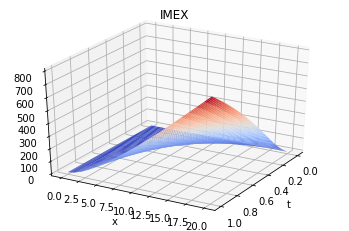

In [38]:
# Testing with a non - convex solution

ww = BlackScholesPDE(f = butterflySpread, 
                              g0=zero2, g1=one,
                              R = 120, T = 1, 
                              sigma = 0.1, r = 0.02, c = 2, 
                              K = 5, H = 5,
                              stop = 20)

x, t, U = IMEX(ww, 120, 1000, RHS = rhs_u)

plot_solution(x, t, U, txt = "IMEX")

print("---------------------------------------")
print("\n")
print("We see that this is not quite right, but we do not have time to figure out what is wrong.")

In [39]:
def plot_exact_solution(f):
    M=120
    N=1000
    xs = np.linspace(0,R,M+1)
    ts = np.linspace(0,1, N+1)
    fig=plt.figure()
    ax = fig.gca(projection='3d')
    X,T = np.meshgrid(xs, ts) # grid of point
    Z = f(X, T) # evaluation of the function on the grid
    ax.plot_surface(T, X, Z, cmap=cm.coolwarm)
    ax.view_init(azim=30)
    plt.title("Analytical solution")

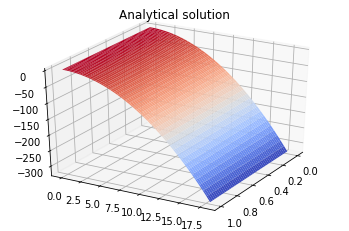

In [40]:
plot_exact_solution(uex)